# Imports and Device Setup

In [63]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
import noisereduce as nr
import soundfile as sf
from collections import Counter
import pandas as pd
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Exact Dataset Path

In [64]:
dataset_path = r"C:\Users\Jim\Jupiter Projects\CSE499\BanglaMOOD"
reduced_audio_path = r"D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\Noise Reduced Data"
augmented_audio_path = r"D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\Augmented Data"

# Data Preprocessing Functions

In [65]:
def standardize_audio(file_path, target_length=5, sample_rate=16000):
    try:
        waveform, sr = librosa.load(file_path, sr=sample_rate)
        target_samples = int(target_length * sample_rate)
        if len(waveform) < target_samples:
            waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
        else:
            waveform = waveform[:target_samples]
        return waveform, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        raise

def augment_to_target(paths, labels, target_count=506, augmented_base_path=augmented_audio_path):
    print("Starting augmentation...")
    label_counts = Counter(labels)
    all_paths, all_labels = paths.copy(), labels.copy()
    
    for label in label_counts:
        original_count = label_counts[label]
        print(f"Label {label}: {original_count} original samples")
        label_dir = os.path.join(augmented_base_path, label)
        os.makedirs(label_dir, exist_ok=True)
        
        existing_files = [f for f in os.listdir(label_dir) if f.endswith(".wav")]
        total_current = original_count + len(existing_files)
        
        if total_current >= target_count:
            print(f"  Reusing existing files for {label}: {total_current} samples already exist")
            for f in existing_files:
                file_path = os.path.join(label_dir, f)
                if file_path not in all_paths:
                    all_paths.append(file_path)
                    all_labels.append(label)
            continue
        
        for f in existing_files:
            os.remove(os.path.join(label_dir, f))
        print(f"  Cleared {len(existing_files)} existing files in {label_dir} (needed {target_count}, had {total_current})")
        
        label_paths = [p for p, l in zip(paths, labels) if l == label]
        needed = target_count - original_count
        aug_types = ["pitch_1", "pitch_2", "pitch_neg_1", "pitch_neg_2", "stretch_1.05", "stretch_1.1", "noise_0.005"]
        aug_idx = 0
        
        while needed > 0 and aug_idx < target_count * 2:
            orig_idx = aug_idx // len(aug_types) % len(label_paths)
            aug_type = aug_types[aug_idx % len(aug_types)]
            waveform, sr = standardize_audio(label_paths[orig_idx])
            base_name = os.path.basename(label_paths[orig_idx]).replace(".wav", "")
            
            if aug_type.startswith("pitch"):
                n_steps = float(aug_type.split("_")[1]) if "neg" not in aug_type else -float(aug_type.split("_")[2])
                augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                file_name = f"{base_name}_pitch_{n_steps}_{aug_idx}.wav"
            elif aug_type.startswith("stretch"):
                rate = float(aug_type.split("_")[1])
                augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                file_name = f"{base_name}_stretch_{rate}_{aug_idx}.wav"
            elif aug_type.startswith("noise"):
                noise_level = float(aug_type.split("_")[1])
                noise = np.random.normal(0, noise_level, waveform.shape)
                augmented = waveform + noise
                file_name = f"{base_name}_noise_{noise_level}_{aug_idx}.wav"
            
            aug_path = os.path.join(label_dir, file_name)
            sf.write(aug_path, augmented, sr)
            if aug_path not in all_paths:
                all_paths.append(aug_path)
                all_labels.append(label)
            needed -= 1
            aug_idx += 1
        
        print(f"  Augmented {label} to {len([l for l in all_labels if l == label])} samples")
    
    total_samples = len(all_paths)
    print(f"Total augmented samples: {total_samples}")
    if total_samples < 8 * target_count:
        print(f"Warning: Only {total_samples} samples generated, expected {8 * target_count}")
    return all_paths, all_labels

def reduce_noise(waveform, sr, output_path, label):
    if label in ["fear", "disgust", "disappointed"]:
        reduced = nr.reduce_noise(y=waveform, sr=sr, prop_decrease=0.3)
    else:
        reduced = nr.reduce_noise(y=waveform, sr=sr, prop_decrease=0.7)
    sf.write(output_path, reduced, sr)
    if not os.path.exists(output_path):
        raise Exception(f"Failed to write {output_path}")
    return output_path

# Dataset Loading Functions

In [66]:
def load_banglamood_dataset(dataset_path, target_length=3):
    paths, labels = [], []
    emotion_folders = ["Happy", "Sad", "Angry", "Neutral", "Surprised", "Fear", "Disappointed", "Excitement"]
    
    for emotion in emotion_folders:
        emotion_path = os.path.join(dataset_path, emotion)
        if not os.path.isdir(emotion_path):
            print(f"Skipping {emotion_path}: not a directory")
            continue
        num_files = len([f for f in os.listdir(emotion_path) if f.endswith(".wav")])
        print(f"{emotion}: {num_files} files")
        for file in os.listdir(emotion_path):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_path, file)
                paths.append(file_path)
                labels.append(emotion.lower())
    print(f"BanglaMOOD: {len(paths)} files loaded")
    return paths, labels

def process_and_reduce_noise(paths, labels, reduced_base_path):
    reduced_paths, reduced_labels = [], []
    for path, label in zip(paths, labels):
        if not os.path.exists(path):
            print(f"Warning: {path} does not exist, skipping")
            continue
        label_dir = os.path.join(reduced_base_path, label)
        os.makedirs(label_dir, exist_ok=True)
        base_name = os.path.basename(path).replace(".wav", "_reduced.wav")
        reduced_file = os.path.join(label_dir, base_name)
        if not os.path.exists(reduced_file):
            waveform, sr = standardize_audio(path)
            reduce_noise(waveform, sr, reduced_file, label)
        reduced_paths.append(reduced_file)
        reduced_labels.append(label)
    print(f"Total reduced samples: {len(reduced_paths)}")
    return reduced_paths, reduced_labels

# Feature Extraction and Dataset Class

In [67]:
def extract_combined_features(file_path, sample_rate=16000, n_mfcc=60, n_mels=80, n_frames=300):
    waveform, sr = librosa.load(file_path, sr=sample_rate)
    
    # MFCC
    mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, hop_length=len(waveform)//(n_frames-1))
    if mfcc.shape[1] < n_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, n_frames - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :n_frames]
        
    # MEL FREQ
    mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=n_mels, hop_length=len(waveform)//(n_frames-1))
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    if log_mel.shape[1] < n_frames:
        log_mel = np.pad(log_mel, ((0, 0), (0, n_frames - log_mel.shape[1])), mode='constant')
    else:
        log_mel = log_mel[:, :n_frames]
    return np.concatenate((mfcc, log_mel), axis=0)  # Shape: (140, 300)

def compute_features_in_memory(paths):
    features = []
    for file_path in paths:
        feat = extract_combined_features(file_path)
        features.append(feat)
    return features

class AudioDataset(Dataset):
    def __init__(self, features, labels, label_map):
        self.features = features
        self.labels = [label_map[l] for l in labels]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Model Definition

In [68]:
class CNNBackbones(nn.Module):
    def __init__(self):
        super(CNNBackbones, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv1d(140, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.pool1 = nn.MaxPool1d(2)
        self.block2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.pool2 = nn.AdaptiveMaxPool1d(31)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        return x

class CNNTransformerHybrid(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNTransformerHybrid, self).__init__()
        self.cnn = CNNBackbones()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128, nhead=4, dim_feedforward=512, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Sequential(
            nn.Linear(31 * 256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1) # Switches dimensions to [batch, time, features] format expected by Transformer
        transformer_out = self.transformer(transformer_in)
        combined = torch.cat((cnn_out.permute(0, 2, 1), transformer_out), dim=-1)
        combined = combined.reshape(combined.size(0), -1)
        out = self.fc(combined)
        return out

# Training and Evaluation Functions

In [69]:
# [batch, features, time]
# Input: (64, 80, 300)
# CNN Block 1 Conv: (64, 64, 300)
# CNN Block 1 Pool: (64, 64, 150)
# CNN Block 2 Conv: (64, 128, 150)
# CNN Block 2 Pool: (64, 128, 31)
# [batch, time, features]
# Transformer Input: (64, 31, 128)
# Transformer Output: (64, 31, 128)
# Fusion Concat: (64, 31, 256)
# Fusion Flatten: (64, 7936)
# FC Linear 1: (64, 512)
# FC Linear 2: (64, 7)

In [70]:
def train_model(model, train_loader, val_loader, num_epochs=500, patience=20):
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=15, min_lr=1e-6)
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 5.0, 5.0], dtype=torch.float32).to(device)  # Higher weights for disappointed, excitement
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1).to(device)
    
    best_val_accuracy = -float('inf')
    best_model_state = None
    patience_counter = 0
    save_path = "CSE499_BanglaMOOD_Model.pth"
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(targets.cpu().numpy())
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(targets.cpu().numpy())
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        scheduler.step(val_accuracy)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            patience_counter = 0
            best_epoch = epoch
            print(f"  New best model saved to {save_path} with Val Accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience counter: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            model.load_state_dict(best_model_state)
            break
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue', alpha=0.7)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green', alpha=0.7)
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch: {best_epoch+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='green', alpha=0.7)
    plt.axvline(x=best_epoch, color='r', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Training complete. Best Val Accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}")
    return model

In [71]:
def evaluate_model(model, test_loader, label_map):
    model = model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    unique_labels = np.unique(all_labels)
    label_map_inv = {v: k for k, v in label_map.items()}
    present_classes = [label_map_inv[i] for i in unique_labels]

    print("Classes present in test set:", present_classes)
    print(classification_report(
        all_labels,
        all_preds,
        labels=unique_labels,
        target_names=present_classes,
        zero_division=0
    ))

    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=present_classes, yticklabels=present_classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    class_counts = np.bincount(all_labels, minlength=len(label_map))
    class_acc = [cm[i, i] / class_counts[unique_labels[i]] for i in range(len(unique_labels)) if class_counts[unique_labels[i]] > 0]
    weighted_acc = np.sum(class_acc * class_counts[unique_labels] / len(all_labels))
    print(f"Weighted Accuracy: {weighted_acc:.4f}")
    return weighted_acc

# Visualization of Class Distribution

In [72]:
def plot_class_distribution(original_labels, augmented_labels, label_map, title_suffix=""):
    plt.figure(figsize=(12, 6))
    original_counts = Counter(original_labels)
    augmented_counts = Counter(augmented_labels)
    emotions = list(label_map.keys())
    original_values = [original_counts.get(emotion, 0) for emotion in emotions]
    augmented_values = [augmented_counts.get(emotion, 0) for emotion in emotions]
    df = pd.DataFrame({
        'Emotion': emotions * 2,
        'Count': original_values + augmented_values,
        'Dataset': ['Original'] * len(emotions) + ['Augmented'] * len(emotions)
    })
    ax = sns.barplot(x='Emotion', y='Count', hue='Dataset', data=df, palette=['#1f77b4', '#ff7f0e'])
    plt.title(f'Class Distribution Before and After Augmentation {title_suffix}', fontsize=14)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 5),
                   textcoords='offset points')
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

In [73]:
def plot_sample_features(dataset, label_map_inv, emotion=None, num_samples=2):
    plt.figure(figsize=(16, 6 * num_samples))
    sample_count = 0
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    
    for idx in indices:
        if sample_count >= num_samples:
            break
        features, label_idx = dataset[idx]
        if emotion and label_map_inv[label_idx.item()] != emotion:
            continue
        features = features.numpy()
        emotion_label = label_map_inv[label_idx.item()]
        
        mfcc = features[:60]  # Updated to match n_mfcc=60
        log_mel = features[60:]  # Updated to match n_mels=80
        
        plt.subplot(num_samples, 2, sample_count * 2 + 1)
        librosa.display.specshow(mfcc, x_axis='time', sr=16000, hop_length=160, cmap='coolwarm')
        plt.colorbar(format='%+2.1f dB')
        plt.title(f'MFCCs - Emotion: {emotion_label}\n(Sample {idx})')
        
        plt.subplot(num_samples, 2, sample_count * 2 + 2)
        librosa.display.specshow(log_mel, x_axis='time', y_axis='mel', sr=16000, hop_length=160, fmax=8000, cmap='magma')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Log-Mel Spectrogram')
        
        sample_count += 1
    
    if sample_count == 0:
        print(f"No samples found for emotion: {emotion}")
    plt.tight_layout()
    plt.show()

# Main Execution

### Load Dataset and Augment

In [74]:
# Load BanglaMOOD dataset
paths, labels = load_banglamood_dataset(dataset_path)
print(f"Original samples: {len(paths)}")

# Augment to 506 samples per class
augmented_paths, augmented_labels = augment_to_target(paths, labels, target_count=500)

# Define label map with 8 classes
label_map = {"neutral": 0, "happy": 1, "sad": 2, "angry": 3, "surprised": 4, "fear": 5, "disappointed": 6, "excitement": 7}
label_map_inv = {v: k for k, v in label_map.items()}

# Compute features in memory
print("Computing features in memory...")
all_features = compute_features_in_memory(augmented_paths)
dataset = AudioDataset(all_features, augmented_labels, label_map)
print(f"Total samples: {len(dataset)}")



Happy: 294 files
Sad: 334 files
Angry: 621 files
Neutral: 685 files
Surprised: 273 files
Fear: 430 files
Disappointed: 326 files
Excitement: 257 files
BanglaMOOD: 3220 files loaded
Original samples: 3220
Starting augmentation...
Label happy: 294 original samples
  Cleared 0 existing files in D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\Augmented Data\happy (needed 500, had 294)
  Augmented happy to 500 samples
Label sad: 334 original samples
  Cleared 0 existing files in D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\Augmented Data\sad (needed 500, had 334)
  Augmented sad to 500 samples
Label angry: 621 original samples
  Reusing existing files for angry: 621 samples already exist
Label neutral: 685 original samples
  Reusing existing files for neutral: 685 samples already exist
Label surprised: 273 original samples
  Cleared 0 existing files in D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\Augmented Data\surprised (needed 500, had 273)
  Augmented surprised to 500 samples

### Visualize

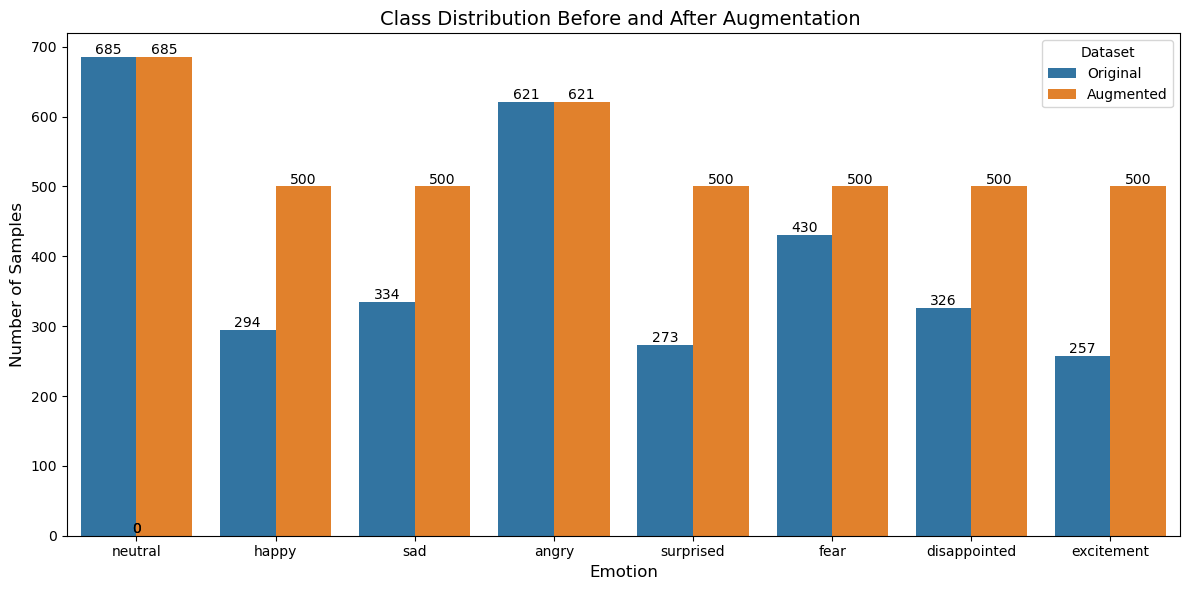

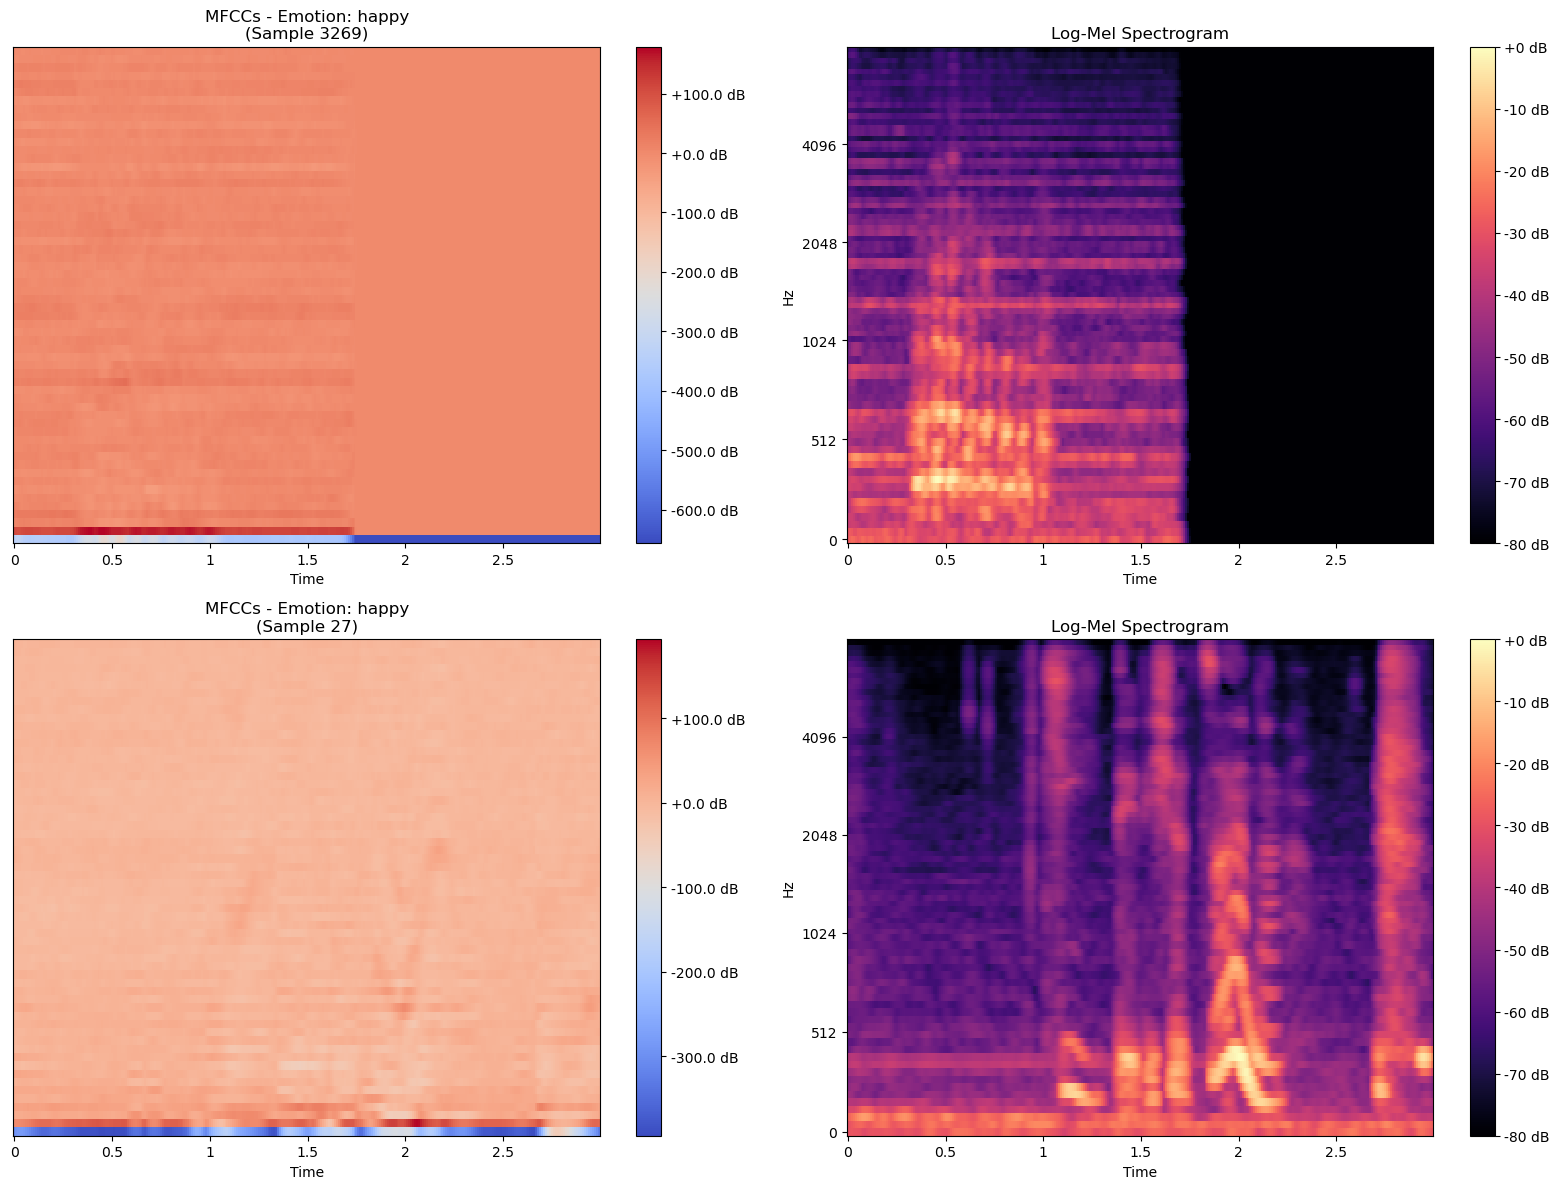

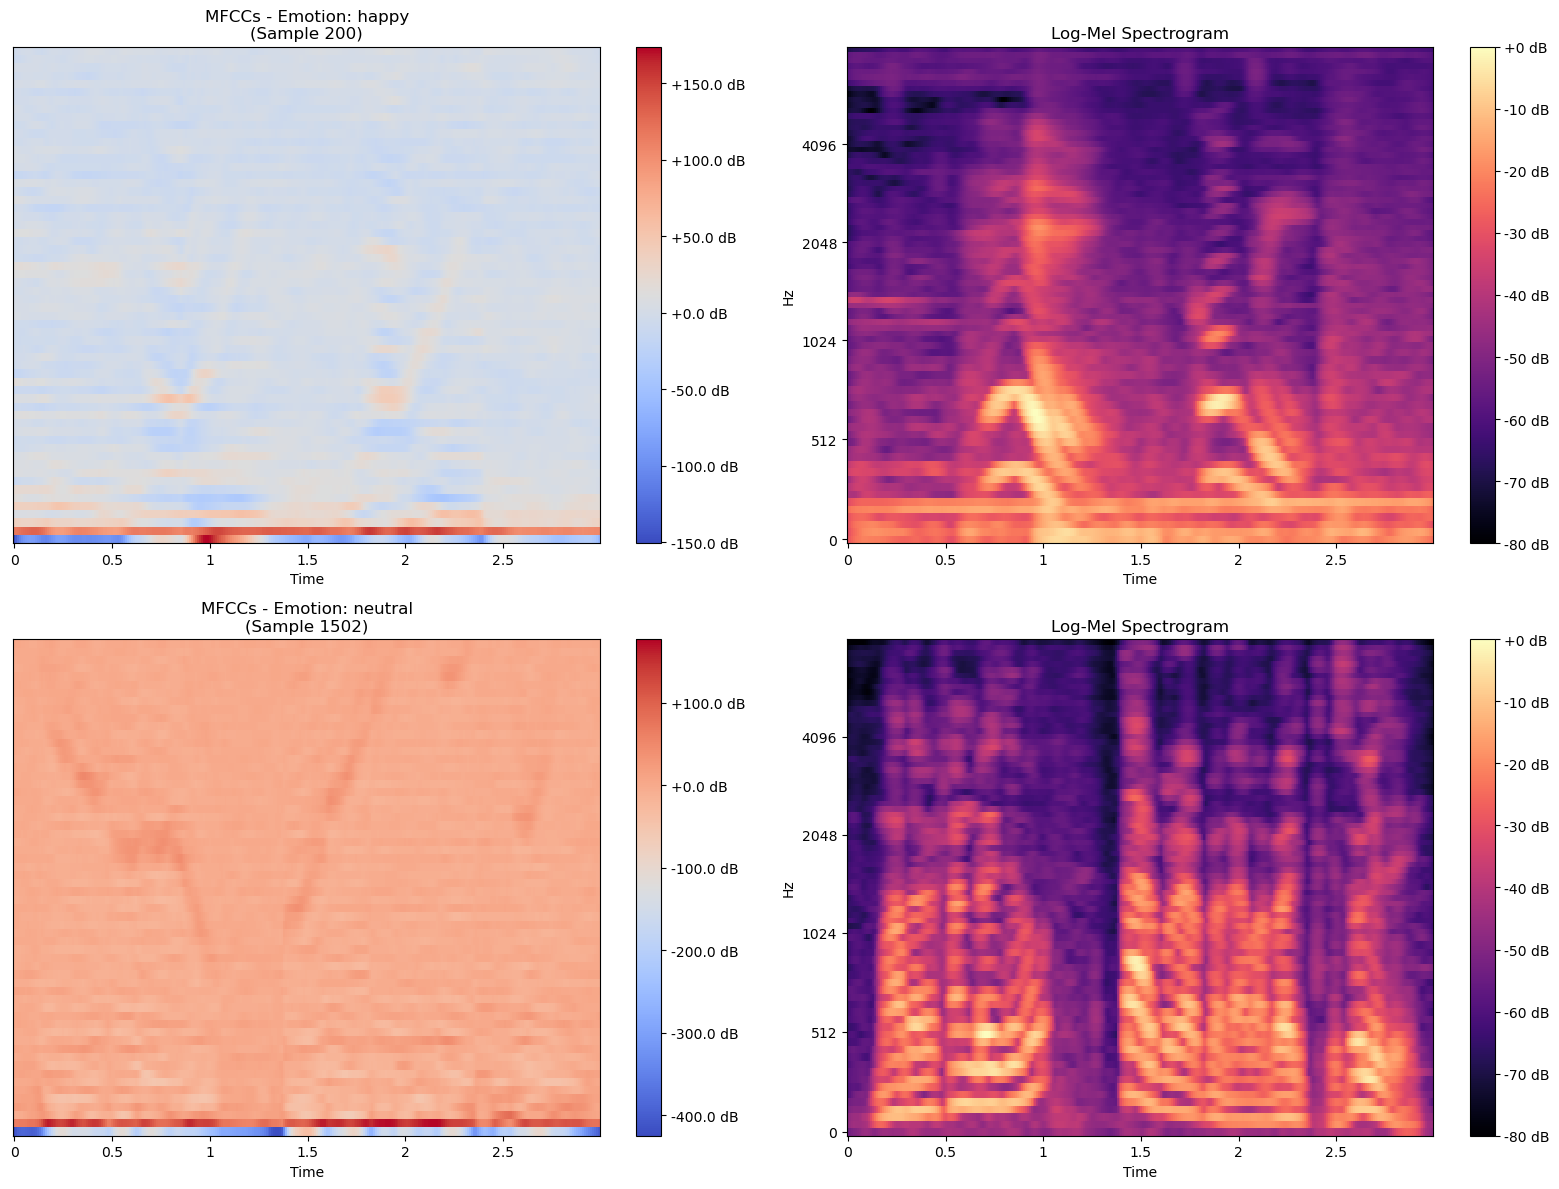

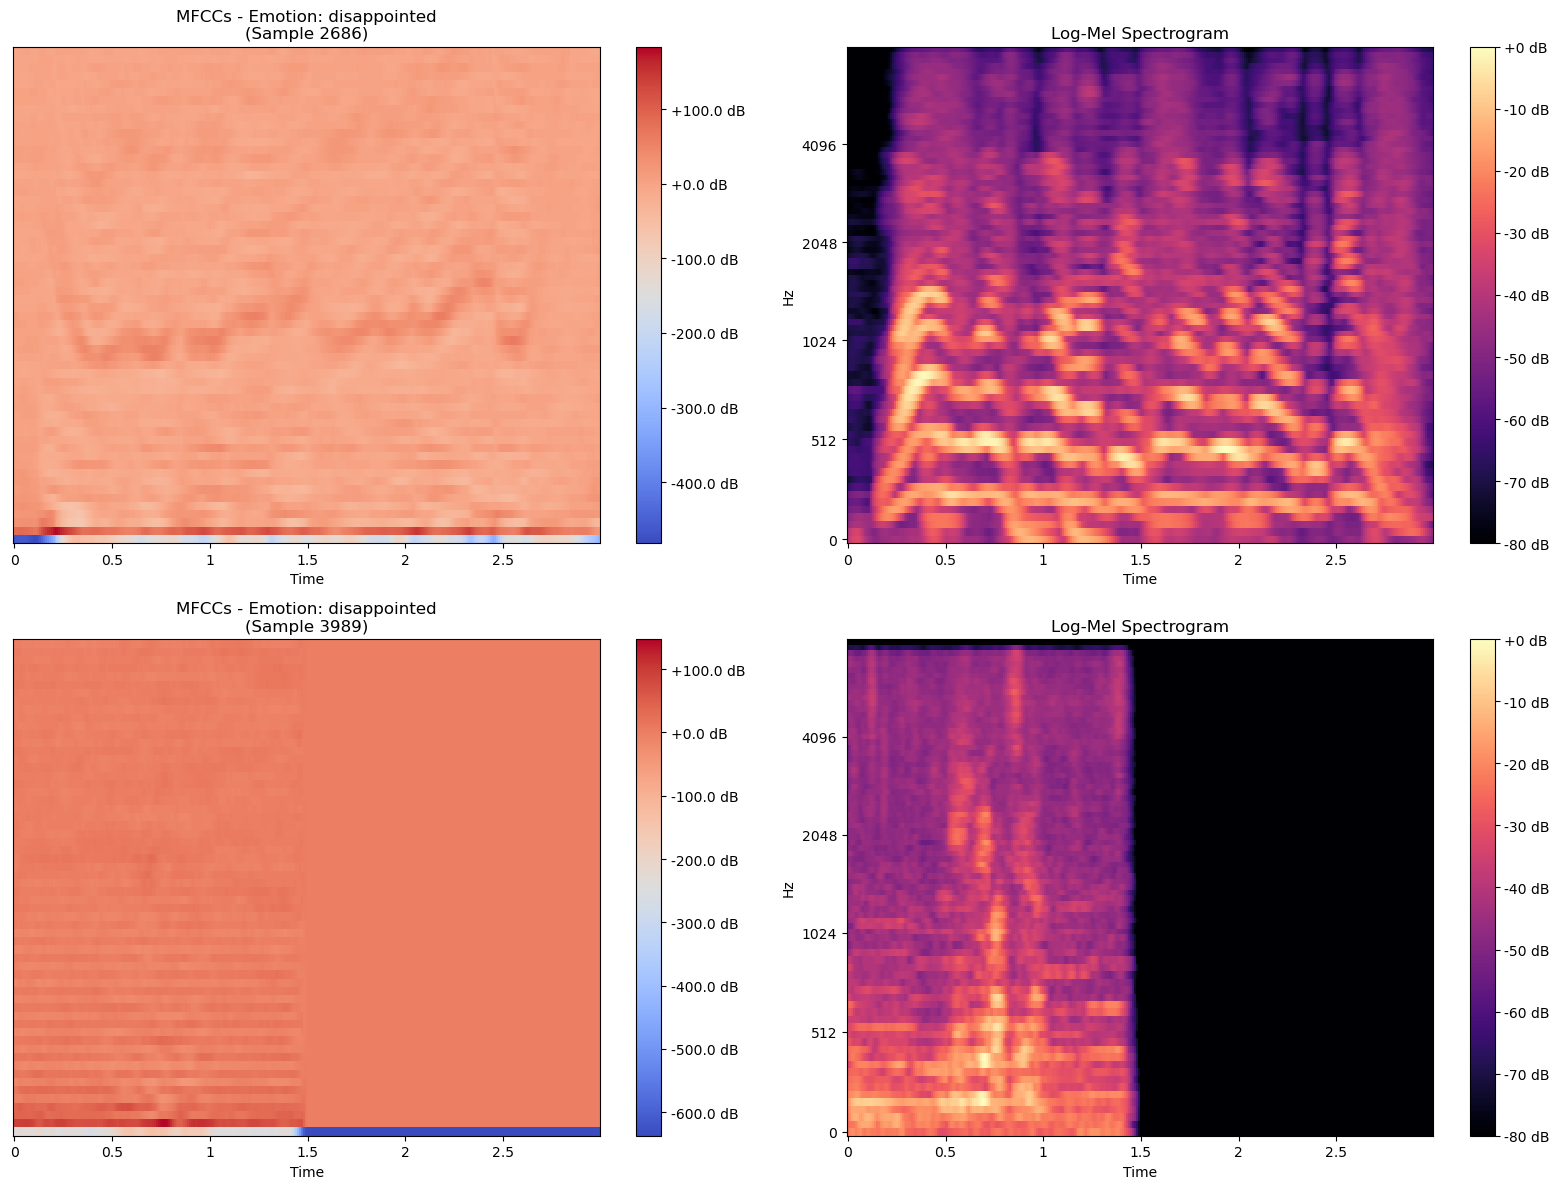

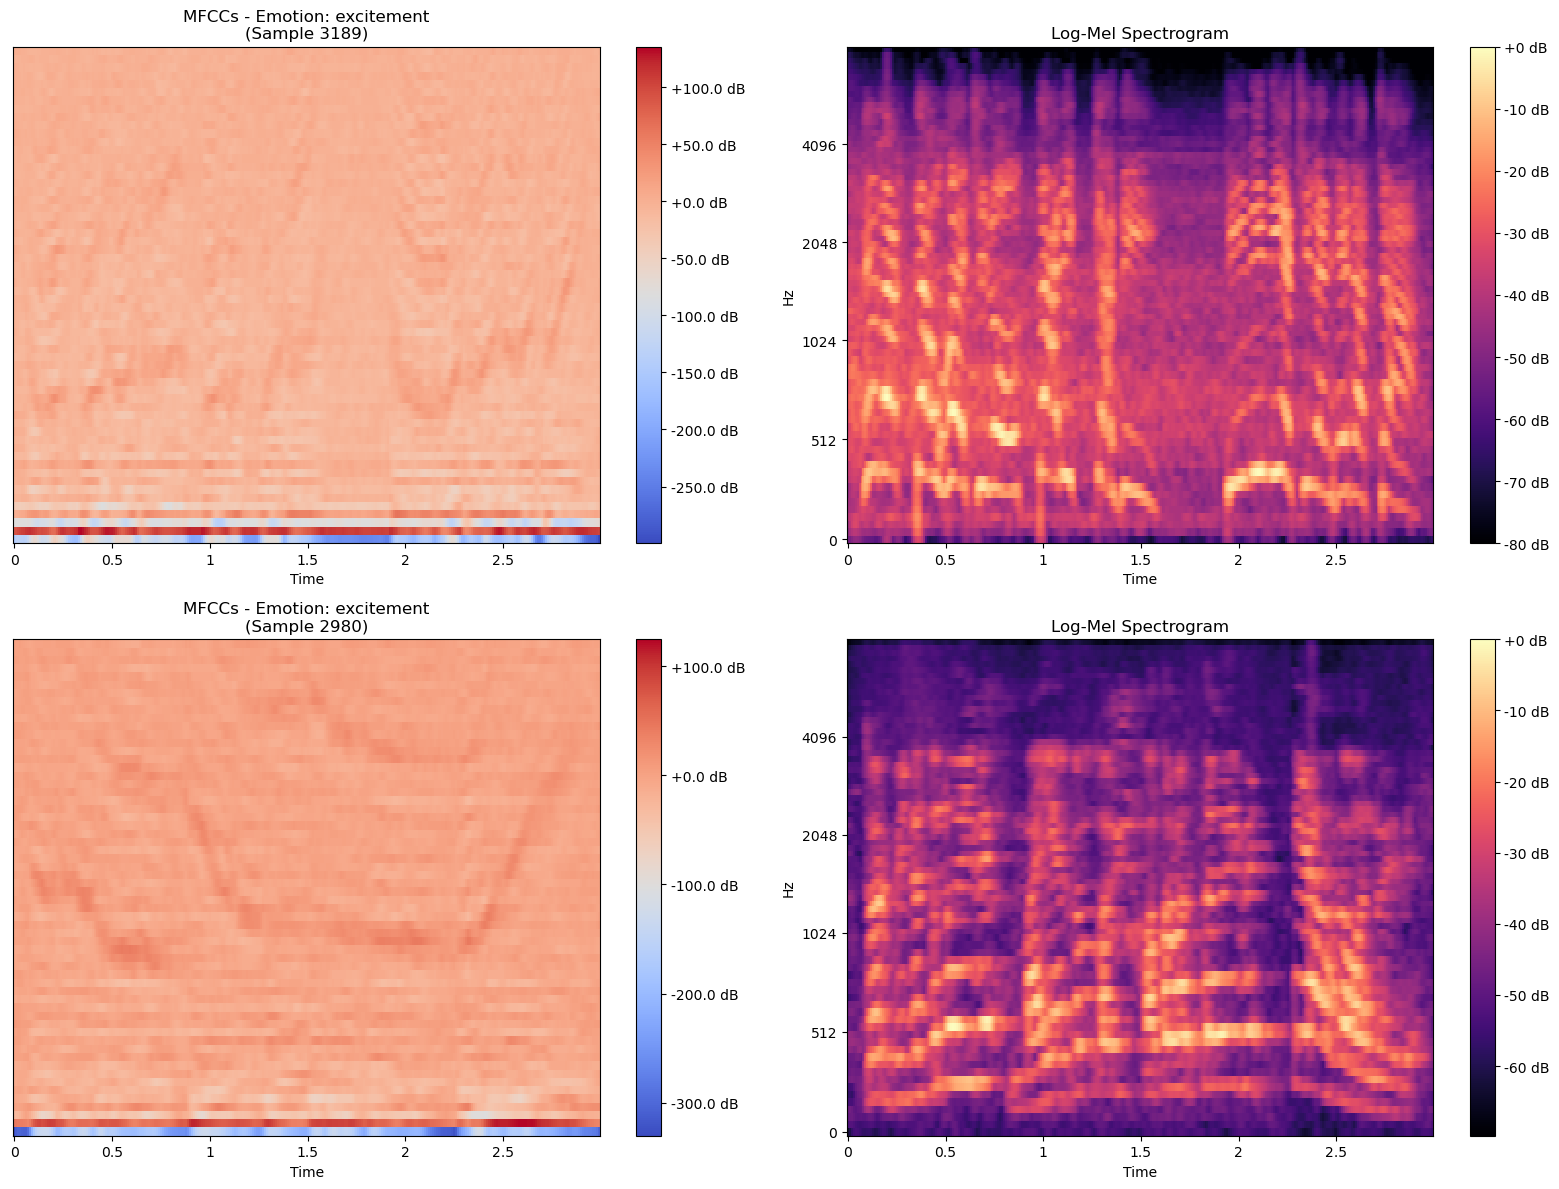

In [75]:
# Visualize class distribution
plot_class_distribution(labels, augmented_labels, label_map)

# Visualize random samples
plot_sample_features(dataset, label_map_inv)
plot_sample_features(dataset, label_map_inv)

# Visualize random samples for disappointed and excitement
plot_sample_features(dataset, label_map_inv, emotion="disappointed", num_samples=2)
plot_sample_features(dataset, label_map_inv, emotion="excitement", num_samples=2)

### Split and Prepare Data Loaders

In [76]:
# Stratified split
numerical_labels = [label_map[label] for label in augmented_labels]
print(f"Label distribution: {np.bincount(numerical_labels)}")

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(sss.split(np.zeros(len(dataset)), numerical_labels))
train_val_labels = [numerical_labels[i] for i in train_val_idx]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(train_val_idx)), train_val_labels))

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
test_labels = [dataset[i][1].item() for i in test_idx]
print(f"Test set label distribution: {np.bincount(test_labels)}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=0, pin_memory=True)
print(f"Train batches: {len(train_loader)}")

Label distribution: [685 500 500 621 500 500 500 500]
Train samples: 3013, Val samples: 431, Test samples: 862
Test set label distribution: [137 100 100 125 100 100 100 100]
Train batches: 48


# Model Training and Evaluation

Total parameters: 4516424
Starting training...
Epoch 1/500, Train Loss: 1.9610, Val Loss: 1.8511, Train Accuracy: 0.2210, Val Accuracy: 0.1995, LR: 0.000500
  New best model saved to CSE499_BanglaMOOD_Model.pth with Val Accuracy: 0.1995
Epoch 2/500, Train Loss: 1.6687, Val Loss: 1.8710, Train Accuracy: 0.2881, Val Accuracy: 0.2877, LR: 0.000500
  New best model saved to CSE499_BanglaMOOD_Model.pth with Val Accuracy: 0.2877
Epoch 3/500, Train Loss: 1.6231, Val Loss: 1.9238, Train Accuracy: 0.3342, Val Accuracy: 0.1833, LR: 0.000500
  No improvement. Patience counter: 1/50
Epoch 4/500, Train Loss: 1.5223, Val Loss: 1.9034, Train Accuracy: 0.3618, Val Accuracy: 0.3016, LR: 0.000500
  New best model saved to CSE499_BanglaMOOD_Model.pth with Val Accuracy: 0.3016
Epoch 5/500, Train Loss: 1.4067, Val Loss: 1.8368, Train Accuracy: 0.4378, Val Accuracy: 0.2691, LR: 0.000500
  No improvement. Patience counter: 1/50
Epoch 6/500, Train Loss: 1.3367, Val Loss: 2.0991, Train Accuracy: 0.4673, Val Ac

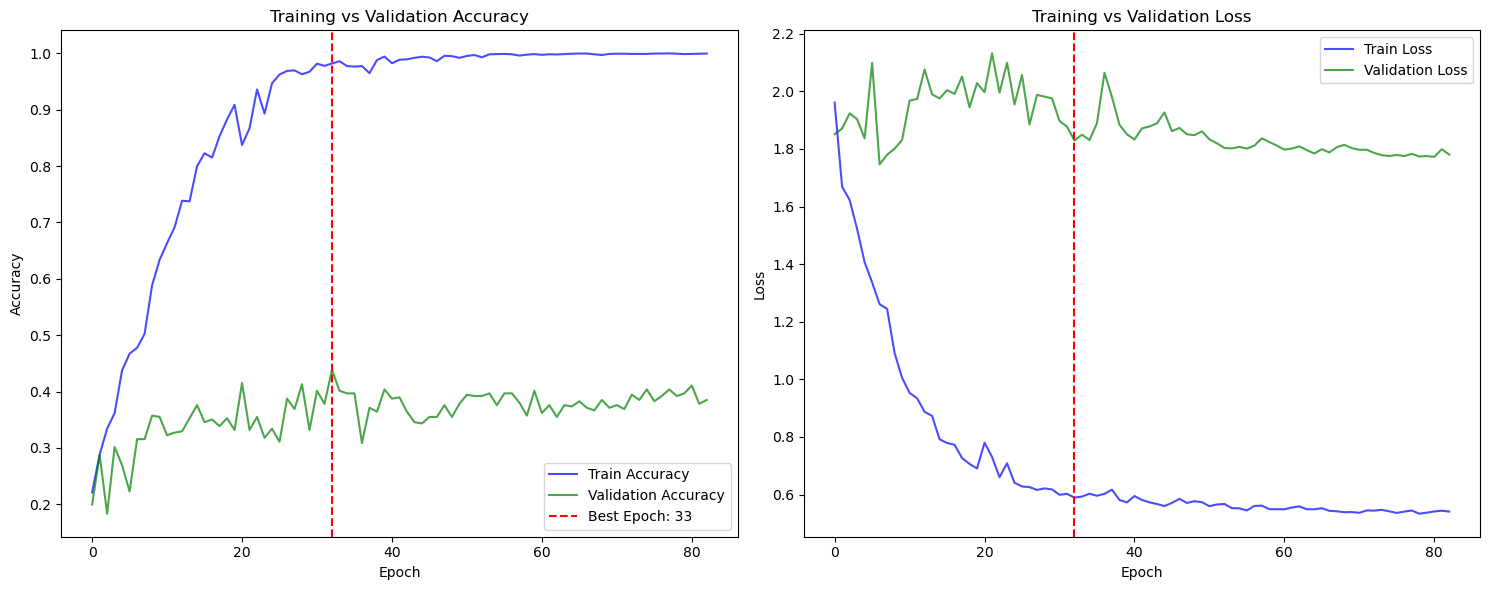

Training complete. Best Val Accuracy: 0.4385 at epoch 33
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprised', 'fear', 'disappointed', 'excitement']
              precision    recall  f1-score   support

     neutral       0.97      0.93      0.95       137
       happy       0.40      0.94      0.56       100
         sad       0.95      0.71      0.81       100
       angry       0.93      0.94      0.93       125
   surprised       0.98      0.45      0.62       100
        fear       0.92      0.80      0.86       100
disappointed       0.76      0.60      0.67       100
  excitement       0.82      0.69      0.75       100

    accuracy                           0.77       862
   macro avg       0.84      0.76      0.77       862
weighted avg       0.85      0.77      0.78       862



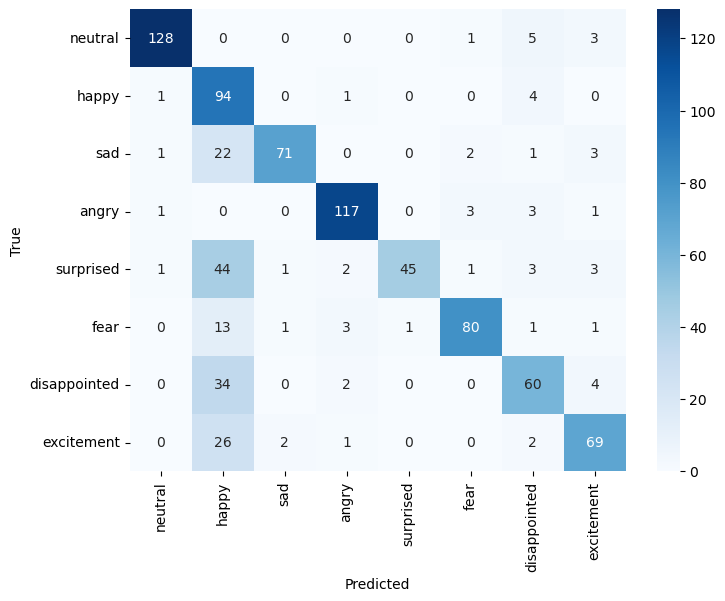

Weighted Accuracy: 0.7703


In [77]:
# Train and evaluate
torch.cuda.empty_cache()
model = CNNTransformerHybrid(num_classes=8).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
print("Starting training...")
model = train_model(model, train_loader, val_loader, num_epochs=500, patience=50)
weighted_acc = evaluate_model(model, test_loader, label_map)

In [78]:
# #Multiple runs (10 times)
# print("\nStarting 10-run evaluation...")
# weighted_accs = []
# num_runs = 10
# for run in range(num_runs):
#     print(f"\nRun {run + 1}/{num_runs}")
#     torch.cuda.empty_cache()
#     model = CNNTransformerHybrid(num_classes=7).to(device)  # Re-initialize model for random weights
#     model = train_model(model, train_loader, val_loader, num_epochs=500, patience=20)
#     weighted_acc = evaluate_model(model, test_loader, label_map)
#     weighted_accs.append(weighted_acc)

# # Compute mean and standard deviation
# mean_acc = np.mean(weighted_accs)
# std_acc = np.std(weighted_accs)
# print(f"\nResults over {num_runs} runs:")
# print(f"Mean Weighted Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")